# Training LSTM network for *homogeneous* circuits where $\theta^i_p = \theta^j_p$
## Network is trained on  random realizations of the circuit with $N=8$ and($p \in[1,20]$), and then is evaluated on $p \in[1,40]$) on unseen samples. Here  both generalization power and extrapolation power (in time)  of LSTM is investigated
 

In [ ]:
import numpy as np
#from qutip import *
from math import sqrt
from scipy import *
import scipy.linalg

from numpy.linalg import eig
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM,Bidirectional
import sys
import scipy.linalg
%matplotlib inline

# Loading data

In [6]:
Result=pd.read_csv("/u/nmohseni/notebooks_bak/data_1/Supremacy/Ising_Expects_k=50,M=8,num=20000,seed=1232,correlation=20.dat", header=None) # Results
# contains the expectation values of all the observables in all time steps (look into Simulating_Dynamics_of_random_circuits.py  module for more information)
Data=pd.read_csv("/u/nmohseni/notebooks_bak/data_1/Supremacy/Ising_Theta_k=50,M=8,num=20000,seed=1232,correlation=20.dat", header=None)


# Training

In [ ]:
def prepare_data(Result_train1, Data_train1, Result_test1, Data_test1, generalization_steps, extrapolation_steps):
    """
    Prepare the data for training and testing by reshaping and combining input features and output labels.

    Parameters:
    - Result_train (list or array): all expectation values for all  time steps for training set. 
    - Data_train (list or array): Random Guassian parameters for all  time steps .
    - Result_test (list or array): all expectation values for all  time steps for test set.
    - Data_test (list or array): Random Guassian parameters for all time steps.
    - generalization_steps (int): Number of generalization steps.
    - extrapolation_steps (int): Number of extrapolation steps.

    Returns:
    - x_train (array): Input features for training data.
    - y_train (array): Output labels for training data.
    - x_test (array): Input features for test data.
    - y_test (array): Output labels for test data.

    Notes:
    - The input of the network is (Theta,<sz,p=0>,<sy,p=0>,<sx,p=0>,p) which has 5 values.  Here the initial values of first order moments
    are fed, but in principle that is not required as all of qubits are initially in the same state |0>
    - Assumes that the lengths of `Result_train`, `Data_train`, `Result_test`, and `Data_test` are consistent.
    - The output arrays (`x_train`, `y_train`, `x_test`, `y_test`) are formatted based on the specified generalization
      and extrapolation steps.
    """


   
    
    Result_train = np.array(Result_train1).reshape(len(Result_train1), extrapolation_steps, 9*(L-1)+3)
    Result_train = Result_train[:, :generalization_steps, :].reshape(len(Result_train), generalization_steps*(9*(L-1)+3))
    Result_test = np.array(Result_test1).reshape(len(Result_test1), extrapolation_steps*(9*(L-1)+3))
    Data_train = np.array(Data_train1)[:, :generalization_steps]
    Data_test = np.array(Data_test1)[:, :extrapolation_steps]
    x_train = np.zeros((len(Data_train), generalization_steps, 5))
    x_test = np.zeros((len(Data_test), extrapolation_steps, 5))

    x_train[:, :, :1] = Data_train.reshape(Data_train.shape[0], generalization_steps, 1)
    x_test[:, :, :1] = Data_test.reshape(Data_test.shape[0], extrapolation_steps, 1)

    x_train[:, 0, 1:4] = Result_train[:, :3]
    x_test[:, 0, 1:4] = Result_test[:, :3]
    x_train[:, :, 4:5] = (np.repeat(Plist_generalization[:, np.newaxis], len(x_train), axis=1).T).reshape(
        len(x_train), generalization_steps, 1)
    x_test[:, :, 4:5] = (np.repeat(Plist_extrapolation[:, np.newaxis], len(x_test), axis=1).T).reshape(
        len(x_test), extrapolation_steps, 1)
    



    y_train = Result_train.reshape(len(Result_train), P_generalization, 9*(L-1)+3)
    y_test = Result_test.reshape(len(Result_test), P_extrapolation, 9*(L-1)+3)



    return x_train, y_train, x_test, y_test


def build_lstm_model(input_shape):
    """
    the input of the network is (Theta,<sz,p=0>,<sy,p=0>,<sx,p=0>,p)  here the initial values of first order moments
    are fed, but in principle that is not required as all of qubits are initially in the same state |0> .
    the output of the network is expectation value of the ovservables 9(L-1)+3
    """
    net = Sequential()
    net.add(LSTM(300, batch_input_shape=input_shape, return_sequences=True))
    net.add(LSTM(400, return_sequences=True))
    net.add(LSTM(400, return_sequences=True))
    net.add(LSTM(300, return_sequences=True))
    net.add(Dense(9*(L-1)+3))
    net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return net


def plot_training_history(history):
    plt.plot(history.history['val_mean_squared_error'], linewidth=3)
    plt.plot(history.history['mean_squared_error'], linewidth=3)
    legend = plt.legend(('MSE_validation', 'MSE_train'))
    plt.xlabel('number of epochs', fontsize=21)
    plt.ylabel('MSE', fontname="cal", fontweight="bold", fontsize=25)
    plt.title('M=7, LSTM', fontsize=25)
    plt.show()
    plt.yscale('log')


P_generalization = 20
P_extrapolation = 40
generalization_steps = 20
extrapolation_steps = 40
Plist_generalization=np.arange(P_generalization)
Plist_extrapolation=np.arange(P_extrapolation)

M = 8
L = int((M-1)/2)+1
Result_train1=np.array(Result)[:39000]
Data_train1=np.array(Data)[:39000,:]
Data_test1=Data[39000:40000]
Result_test1=Result[39000:40000]

# Data Preparation
x_train, y_train, x_test, y_test = prepare_data(Result_train1, Data_train1, Result_test1, Data_test1, generalization_steps, extrapolation_steps)

# Model Creation
input_shape = (None, None, 5)  # Shape of input data (Magnetic_field, <sz,t=0>, <sy,t=0>, <sx,t=0>, time)
net = build_lstm_model(input_shape)

# Model Training
history = net.fit(x=x_train, y=y_train, batch_size=1000, epochs=500, validation_split=0.1)

# Model Evaluation
error = net.evaluate(x=x_test, y=y_test)


Epoch 1/500
18/18 [==============================] - 49s 2s/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0566 - val_mean_squared_error: 0.0566
Epoch 2/500
18/18 [==============================] - 40s 2s/step - loss: 0.0558 - mean_squared_error: 0.0558 - val_loss: 0.0543 - val_mean_squared_error: 0.0543
Epoch 3/500
18/18 [==============================] - 40s 2s/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0531 - val_mean_squared_error: 0.0531
Epoch 4/500
18/18 [==============================] - 40s 2s/step - loss: 0.0531 - mean_squared_error: 0.0531 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 5/500
18/18 [==============================] - 40s 2s/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 0.0488 - val_mean_squared_error: 0.0488
Epoch 6/500
18/18 [==============================] - 40s 2s/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 7/500
18/18 [===============

# MSE on validation (test) and training set

findfont: Font family ['cal'] not found. Falling back to DejaVu Sans.


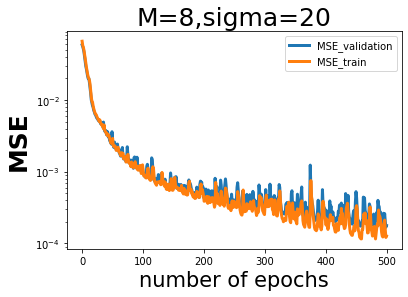

In [11]:

#300N 4L
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'], linewidth=3)
plt.plot(history.history['mean_squared_error'], linewidth=3)
legend=plt.legend(('MSE_validation','MSE_train'))
plt.xlabel('number of epochs',fontsize=21)
plt.ylabel('MSE',fontname="cal",fontweight="bold",fontsize=25)
plt.title('M=8,sigma=20',fontsize=25)
#plt.ylim([0.0001,0.1])
plt.show()

10//3

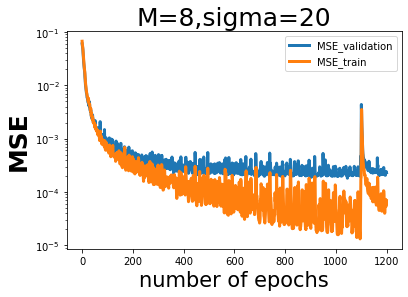

In [20]:

#300N 4L
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'], linewidth=3)
plt.plot(history.history['mean_squared_error'], linewidth=3)
legend=plt.legend(('MSE_validation','MSE_train'))
plt.xlabel('number of epochs',fontsize=21)
plt.ylabel('MSE',fontname="cal",fontweight="bold",fontsize=25)
plt.title('M=8,sigma=20',fontsize=25)
#plt.ylim([0.0001,0.1])
plt.show()

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0161 - mean_squared_error: 0.0161


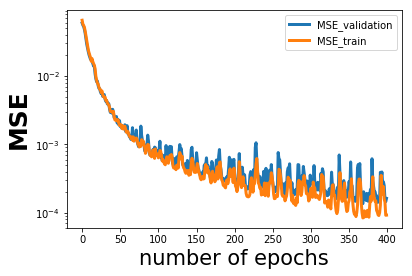

In [57]:
#trained up to 20
plt.yscale('log')

y_predict = net.predict(x_test)
    
error=net.evaluate(x=x_test,y=y_test)
plt.plot(history.history['val_mean_squared_error'], linewidth=3)
plt.plot(history.history['mean_squared_error'], linewidth=3)
legend=plt.legend(('MSE_validation','MSE_train'))
plt.xlabel('number of epochs',fontsize=21)
plt.ylabel('MSE',fontname="cal",fontweight="bold",fontsize=25)
taulist=np.arange(50)

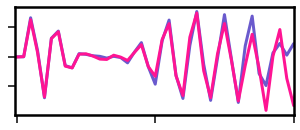

In [38]:
K=40
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['ytick.major.size'] = 7.5
mpl.rcParams['xtick.major.size'] = 7.5
fig, axes = plt.subplots(figsize=(5,2))
color='black'
plt.setp(axes.spines.values(), color=color)
plt.setp(axes.spines.values(), linewidth=5)

for axis in ['top', 'bottom', 'left', 'right']:

    axes.spines[axis].set_linewidth(2.5)

plt.tick_params(labelsize=25)
l=3+2*(L-1)+3
k=1
plt.plot(Plist_extrapolation,np.swapaxes(np.array(y_test),1,2)[k][l],linewidth=3,color='slateblue')
plt.plot(Plist_extrapolation,np.swapaxes(np.array(yy_predict),1,2)[k][l],linewidth=3,color='deeppink')
#plt.axvspan(20, 40, color='cyan', alpha=0.4)
plt.xticks([0,20,40])
plt.yticks([-0.2,0,0.2])
plt.xlim(-0.3,40)
#plt.ylim(-0.6,1)
axes.tick_params(width=1.5,labelbottom=False,axis='x')
axes.tick_params(width=1.5,labelleft=False,axis='y')
axes.tick_params(width=1.5)
#plt.xlabel('Number of modules',size=20)
fig.savefig('Extrapolation_in_time_Ising_sxsz.pdf', transparent=True,format='pdf',bbox_inches='tight')

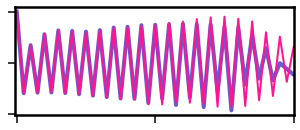

In [37]:
K=40
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['ytick.major.size'] = 7.5
mpl.rcParams['xtick.major.size'] = 7.5
fig, axes = plt.subplots(figsize=(5,2))
color='black'
plt.setp(axes.spines.values(), color=color)
plt.setp(axes.spines.values(), linewidth=5)

for axis in ['top', 'bottom', 'left', 'right']:

    axes.spines[axis].set_linewidth(2.5)

plt.tick_params(labelsize=25)
l=0
k=4
plt.plot(Plist_extrapolation,np.swapaxes(np.array(y_test),1,2)[k][l],linewidth=4,color='slateblue')
plt.plot(Plist_extrapolation,np.swapaxes(np.array(yy_predict),1,2)[k][l],linewidth=2,color='deeppink')
#plt.axvspan(20, 40, color='cyan', alpha=0.4)
plt.xticks([0,20,40])
plt.yticks([-1,0,1])
plt.xlim(-0.3,40)
#plt.ylim(-0.6,1)
axes.tick_params(width=1.5,labelbottom=False,axis='x')
axes.tick_params(width=1.5,labelleft=False,axis='y')
axes.tick_params(width=1.5)
#plt.xlabel('Number of modules',size=20)
fig.savefig('Extrapolation_in_time_Ising_sz.pdf', transparent=True,format='pdf',bbox_inches='tight')

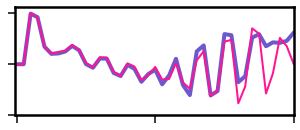

In [36]:
K=40
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['ytick.major.size'] = 7.5
mpl.rcParams['xtick.major.size'] = 7.5
fig, axes = plt.subplots(figsize=(5,2))
color='black'
plt.setp(axes.spines.values(), color=color)
plt.setp(axes.spines.values(), linewidth=5)

for axis in ['top', 'bottom', 'left', 'right']:

    axes.spines[axis].set_linewidth(2.5)

plt.tick_params(labelsize=25)
l=2
k=1
plt.plot(Plist_extrapolation,np.swapaxes(np.array(y_test),1,2)[k][l],linewidth=4,color='slateblue')
plt.plot(Plist_extrapolation,np.swapaxes(np.array(yy_predict),1,2)[k][l],linewidth=2,color='deeppink')
#plt.axvspan(20, 40, color='cyan', alpha=0.4)
plt.xticks([0,20,40])
plt.yticks([-0.5,0,0.5])
plt.xlim(-0.3,40)
#plt.ylim(-0.6,1)
axes.tick_params(width=1.5,labelbottom=False,axis='x')
axes.tick_params(width=1.5,labelleft=False,axis='y')
axes.tick_params(width=1.5)
#plt.xlabel('Number of modules',size=20)
fig.savefig('Extrapolation_in_time_Ising_sx.pdf', transparent=True,format='pdf',bbox_inches='tight')

## Predicted and real values for 18 realizations of the circuit I 
### highlighted parts show the performance of the network in generalization and the rest show the performance of the network in extrapolation

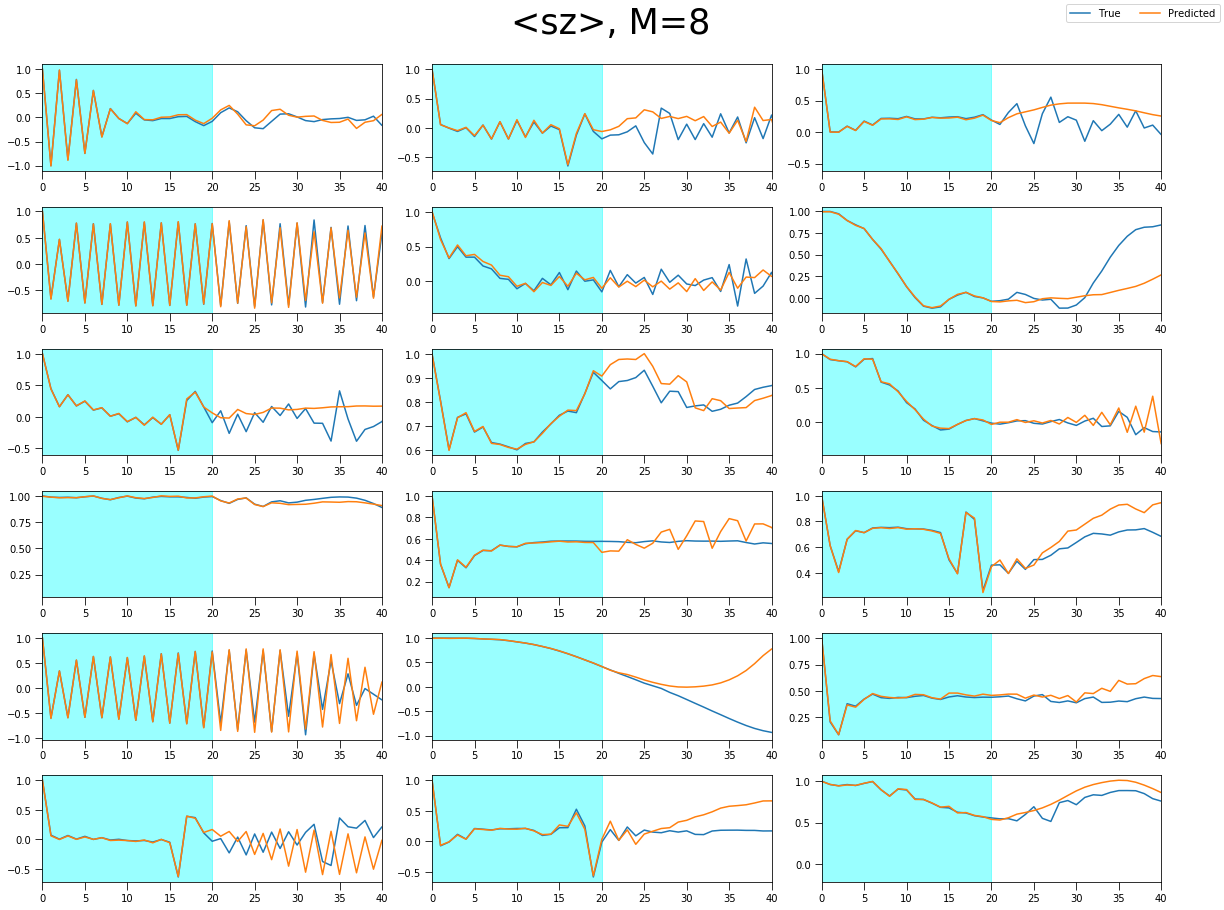

In [29]:
#up to 5
l=0
fig, axes = plt.subplots(6, 3, figsize=(17,12))
fig.tight_layout()
fig.suptitle('<sz>, M=8',size=35, y=1.05)
for j in range(3):
    for k in range(6*j,6*(j+1)):
        
        axes[k-6*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(yy_predict),1,2)[k][l])
        
        axes[k-6*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-6*j,j].set_xlim(0,40)
        
legend=fig.legend(('True','Predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)